In [83]:
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
import os
import pickle


In [74]:
#Import training data
path = r'C:\Users\attic\HLS_Kelp\imagery\rf_training'
files = os.listdir(path)
training_data = []
for file in files:
    with rasterio.open(os.path.join(path, file)) as src:
        training_img = src.read()  
    file_data = training_img.reshape(training_img.shape[0], -1) 
    training_data.append(file_data)

combined_training_data = np.hstack(training_data)

print(combined_training_data.shape)
# plt.figure(figsize=(6, 6))
# plt.imshow(training_img[6,:], cmap='gray')
# plt.show()  



(7, 40186800)


In [76]:
X = file_data[0:5,:].T #figured this out by complete chance, organizes it as the transpose. Good to know !!
y = file_data[6,:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [77]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [85]:
with open(r'C:\Users\attic\HLS_Kelp\random_forest\rf', 'wb') as f:
    pickle.dump(rf, f)

In [82]:

with rasterio.open(r'C:\Users\attic\HLS_Kelp\imagery\rf_prepped\HLS.L30.T11SKU.2018122T183316.v2.0_rf_ready.tif') as test:
    test_img = test.read()
test_data = test_img.reshape(test_img.shape[0], -1).T
print(test_data.shape)
test_data = test_data[:,0:5]

(13395600, 6)


In [78]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9956709665860431


In [80]:
kelp_pred = rf.predict(test_data)


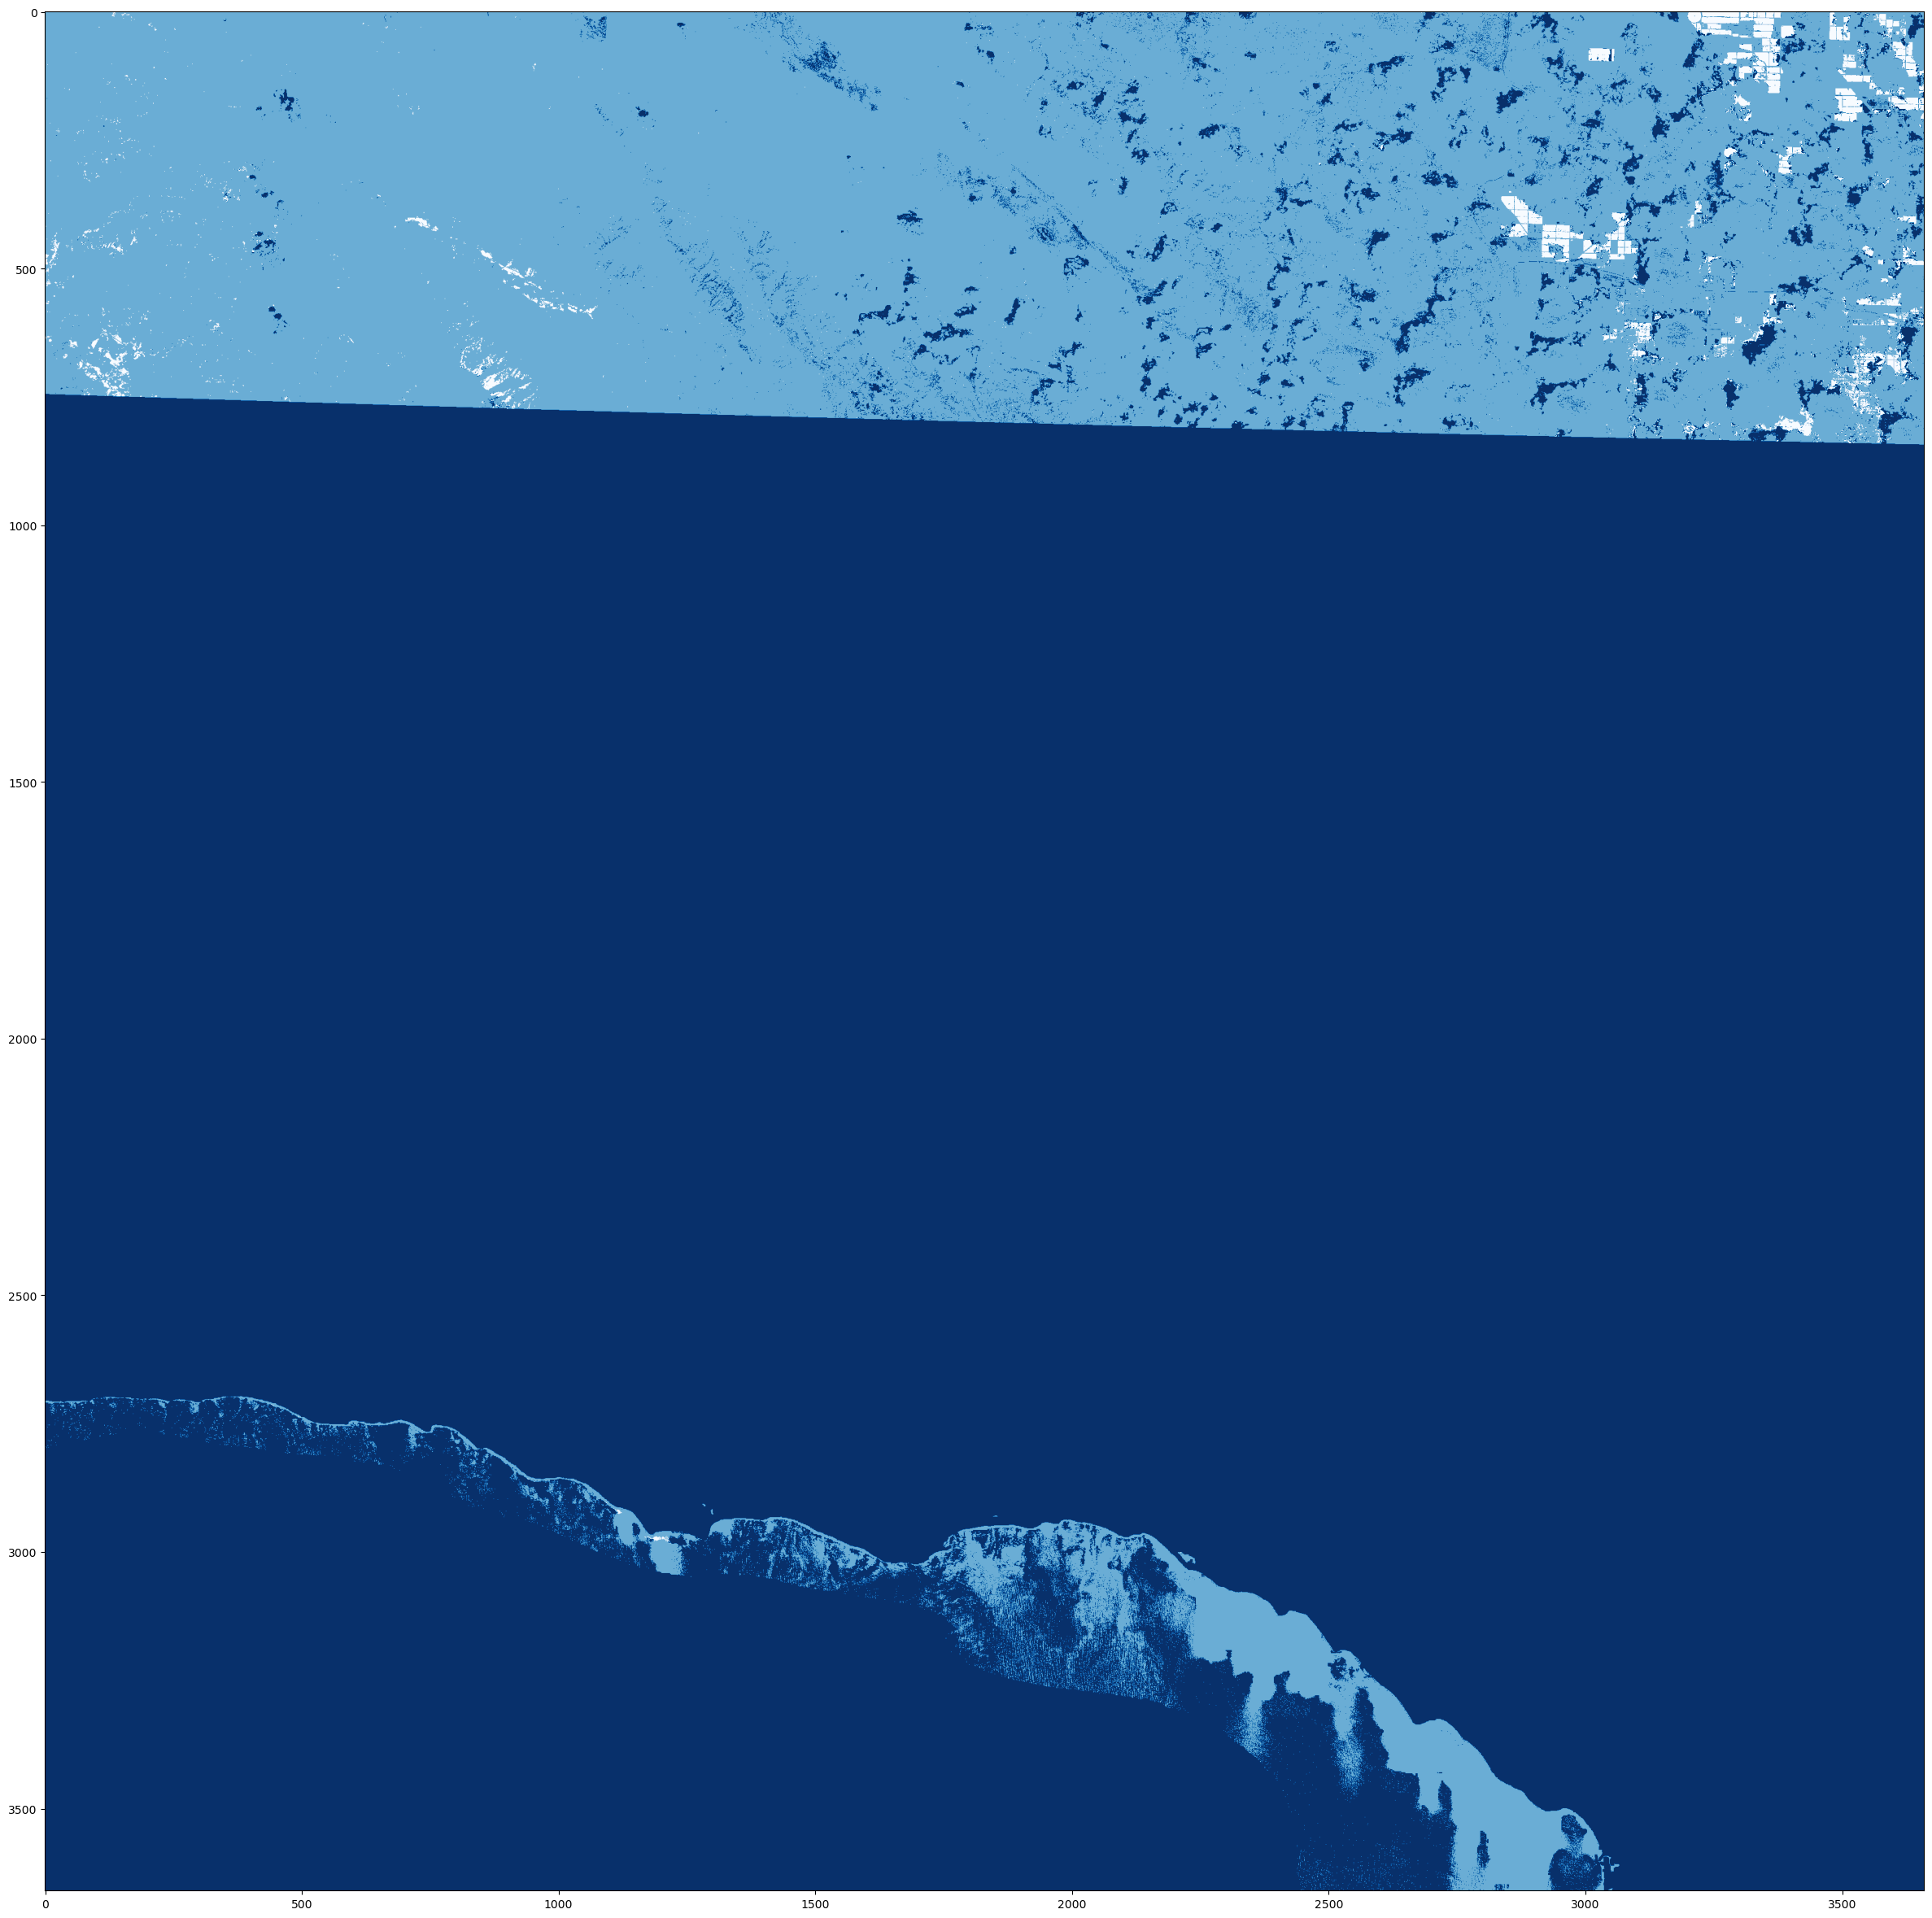

In [81]:
kelp_map = kelp_pred.reshape(3660,3660)

plt.figure(figsize=(30, 30))
plt.imshow(kelp_map, cmap='Blues')

plt.show()  